Virginia's Part: Do companies with higher ESG scores tend to have better stock performance (e.g., returns, volatility)?

In [7]:
# Imports
!pip install yfinance
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [10]:
# 1: Load ESG Data
esg_df = pd.read_csv("esg_data.csv")

# Clean ESG data
esg_df['Ticker'] = esg_df['ticker'].str.strip().str.upper()
esg_df = esg_df[['Ticker', 'name', 'industry', 'environment_score', 'social_score', 'governance_score', 'total_score', 'total_grade']].copy()
esg_df.columns = ['Ticker', 'Company', 'Industry', 'EnvScore', 'SocScore', 'GovScore', 'TotalScore', 'Grade']
esg_df['Industry'].fillna('Unknown', inplace=True)

<ipython-input-10-cfc3a7a1dc25>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  esg_df['Industry'].fillna('Unknown', inplace=True)


In [11]:
# 2: Download stock data from Yahoo Finance
tickers = esg_df['Ticker'].tolist()

# Set time range to last 1 year
end_date = datetime.today()
start_date = end_date - timedelta(days=365)

# Download price data
stock_data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

# Create a list to store return/volatility results
perf_list = []

# Calculate average monthly return and volatility for each ticker
for ticker in tickers:
    try:
        df = stock_data[ticker][['Close']].dropna()
        df['Return'] = df['Close'].pct_change()
        monthly = df['Return'].resample('ME').agg(['mean', 'std'])  # 'ME' = month end
        mean_return = monthly['mean'].mean()
        mean_volatility = monthly['std'].mean()
        perf_list.append({
            'Ticker': ticker,
            'AvgMonthlyReturn': mean_return,
            'AvgMonthlyVolatility': mean_volatility
        })
    except Exception as e:
        print(f"Skipped {ticker}: {e}")

# Save to DataFrame
performance_df = pd.DataFrame(perf_list)

[*********************100%***********************]  722 of 722 completed
ERROR:yfinance:
87 Failed downloads:
ERROR:yfinance:['AGFS', 'AKU', 'ADES', 'MYMD', 'CLSN', 'DISH', 'CLVS', 'HCAR', 'ADMP', 'AESE', 'HAPP', 'HEP', 'GVP', 'AKIC', 'AGIL', 'NLOK', 'HARP', 'ATVI', 'ADOC', 'XL', 'ACAC', 'PEAK', 'MRO', 'CTLT', 'NLSN', 'GPS', 'TRTN', 'USAP', 'ABC', 'ACER', 'UTME', 'ZEV', 'CDAY', 'HA', 'ABMD', 'CLXT', 'POW', 'CTXS', 'PNT', 'HHC', 'HCCI', 'HAYN', 'AKUS', 'SIEN', 'Y', 'SIVB', 'CND', 'AGTC', 'AEY', 'WWE', 'ABTX', 'AIKI', 'ACOR', 'ZEN', 'WRK', 'ABIO', 'AAWW', 'AIH', 'PKI', 'AFAQ', 'ALIM', 'PXD', 'AACI', 'ALBO', 'HAAC', 'USAK', 'AERI', 'FBHS', 'ACEV', 'AIMC', 'FISV', 'AGRX', 'FRC', 'DRE', 'EVK', 'AGLE', 'ZUO', 'HCDI', 'ACRX', 'FLT', 'RE']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:['AHPI', 'MTCR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-04-23 02:00:49.444563 -> 2025-04-23 02:00:49.444563)')
ERROR:yfinance:['MSCI', 'APA', 'FE', 'PLY

In [15]:
# 3: Merge ESG and performance data
performance_df['Ticker'] = performance_df['Ticker'].str.strip().str.upper()
final_df = pd.merge(esg_df, performance_df, on='Ticker')

# Convert score columns to numeric if needed
cols = ['EnvScore', 'SocScore', 'GovScore', 'TotalScore', 'AvgMonthlyReturn', 'AvgMonthlyVolatility']
final_df[cols] = final_df[cols].apply(pd.to_numeric, errors='coerce')

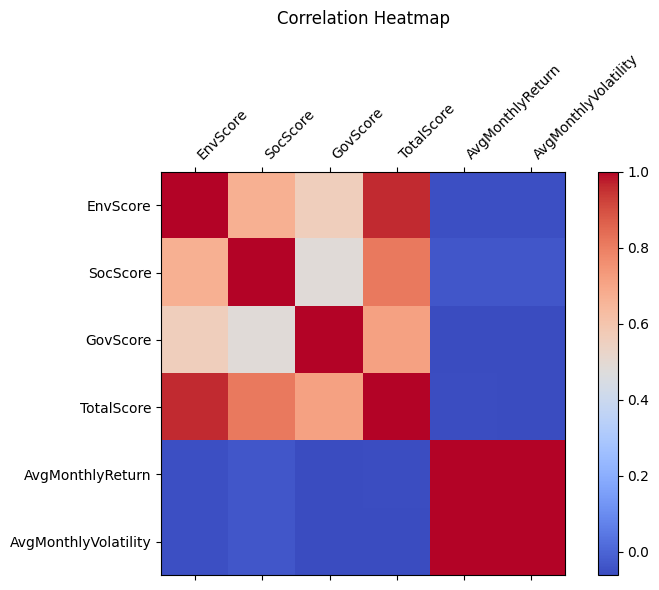

In [25]:
# 4: Correlation matrix
correlation_matrix = final_df[cols].corr()

# Plot correlation heatmap
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
cax = ax.matshow(correlation_matrix, cmap='coolwarm')
fig.colorbar(cax)
ax.set_xticks(range(len(cols)))
ax.set_yticks(range(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha='left')
ax.set_yticklabels(cols)
plt.title("Correlation Heatmap", pad=20)
plt.tight_layout()
plt.show()


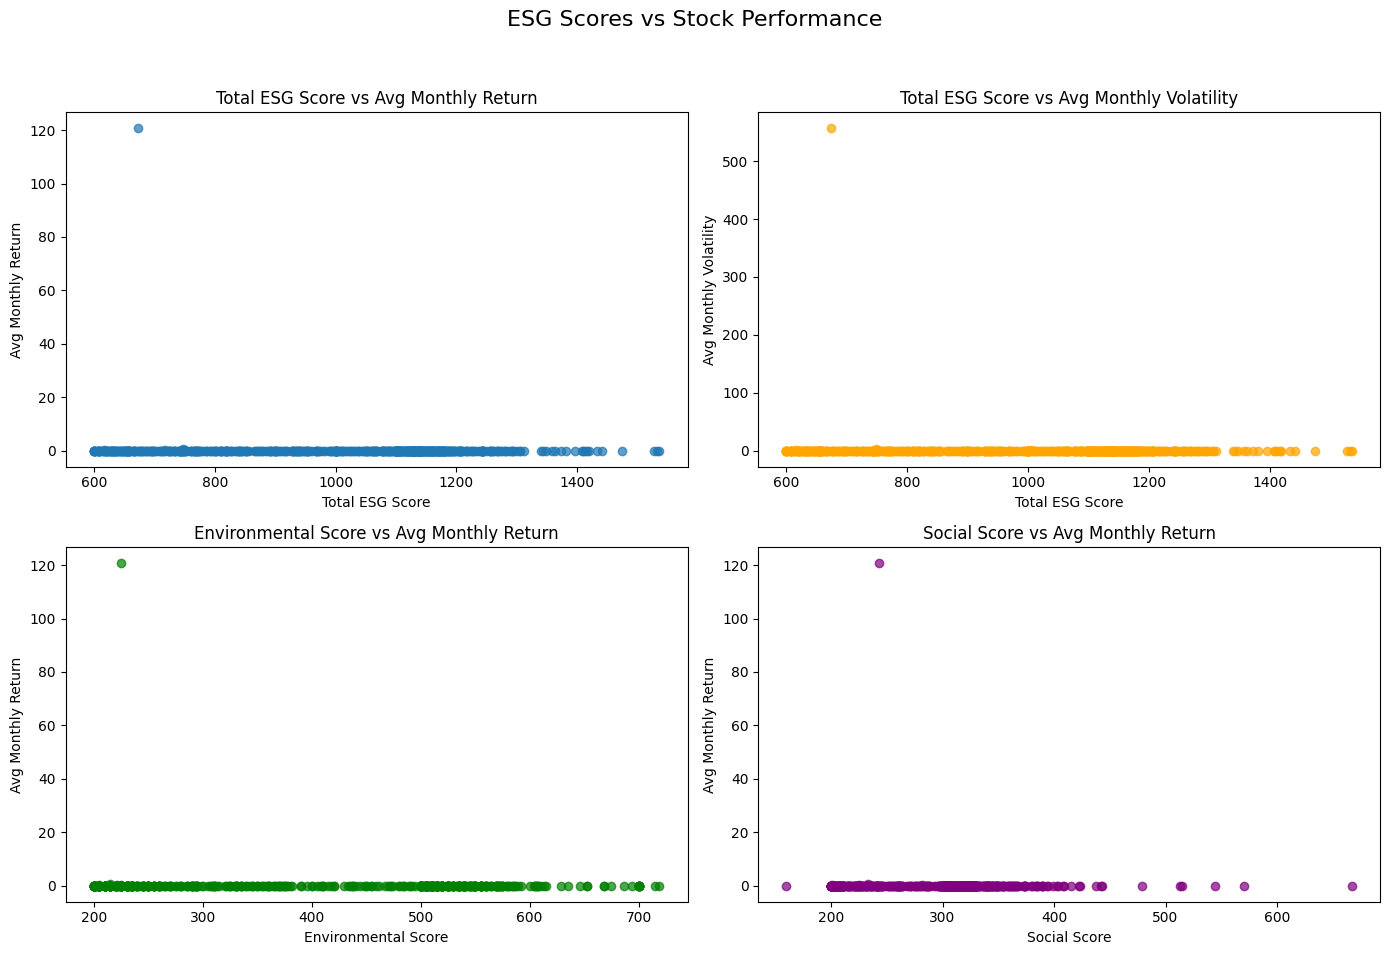

In [23]:
# 5: Scatterplots to visualize relationships
fig = plt.figure(figsize=(14, 10))

# Plot 1
ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(final_df['TotalScore'], final_df['AvgMonthlyReturn'], alpha=0.7)
ax1.set_title('Total ESG Score vs Avg Monthly Return')
ax1.set_xlabel('Total ESG Score')
ax1.set_ylabel('Avg Monthly Return')

# Plot 2
ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(final_df['TotalScore'], final_df['AvgMonthlyVolatility'], alpha=0.7, color='orange')
ax2.set_title('Total ESG Score vs Avg Monthly Volatility')
ax2.set_xlabel('Total ESG Score')
ax2.set_ylabel('Avg Monthly Volatility')

# Plot 3
ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(final_df['EnvScore'], final_df['AvgMonthlyReturn'], alpha=0.7, color='green')
ax3.set_title('Environmental Score vs Avg Monthly Return')
ax3.set_xlabel('Environmental Score')
ax3.set_ylabel('Avg Monthly Return')

# Plot 4
ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(final_df['SocScore'], final_df['AvgMonthlyReturn'], alpha=0.7, color='purple')
ax4.set_title('Social Score vs Avg Monthly Return')
ax4.set_xlabel('Social Score')
ax4.set_ylabel('Avg Monthly Return')

# Title for entire figure
fig.suptitle('ESG Scores vs Stock Performance', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()